In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [13]:
def custom_activation(x):
    return tf.sin(x)

In [14]:
NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((2,)),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=1),
    ]
)

NN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mean_squared_error")

In [16]:
tf_pi = tf.constant(np.pi)


def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

### Params

In [17]:
grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 4

In [18]:
x = np.linspace(x_limits[0], x_limits[1], border_grid_size[0], dtype=np.float32)
y = np.linspace(y_limits[0], y_limits[1], border_grid_size[1], dtype=np.float32)
# y = np.random.uniform(1, 10, 10)
x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))

border = train_coord.reshape(border_grid_size[0], border_grid_size[1], 2)
border_01 = np.append(border[0], border[0][..., [1, 0]])
border_02 = np.append(border[border_grid_size[0] - 1], border[border_grid_size[0] - 1][..., [1, 0]])
border = np.append(border_01, border_02).reshape(border_grid_size[0] * 4, 2)

x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)
y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)

x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))
# train_coord = x
train_loss_record = []

In [19]:
@tf.function
def ode_system(coord, net, border):
    print(border)
    # set type to avoid overcalculations
    # border = tf.constant(border, dtype=tf.float32)
    # coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

Tensor("border:0", shape=(200, 2), dtype=float32)
epoch: 0 loss: 93.754395
epoch: 500 loss: 0.61736584
epoch: 1000 loss: 0.084782735
epoch: 1500 loss: 0.023971913
epoch: 2000 loss: 0.012049166
epoch: 2500 loss: 0.007585329


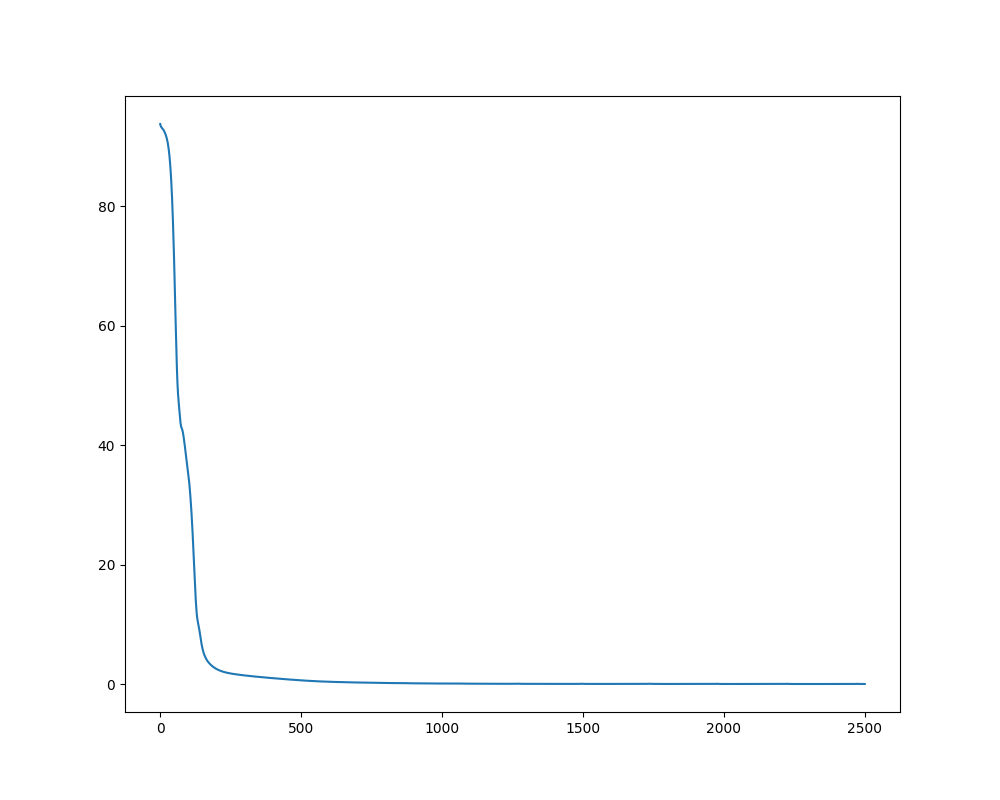

In [20]:
# train model
# /physical_device:GPU:0
# with tf.device('gpu:0'):
def train():
    for itr in range(6000):
        with tf.GradientTape() as tape:
            train_loss = ode_system(train_coord, NN, border)
            train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

        if itr % 500 == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss.numpy())   
            if train_loss < 0.01:
                break

train()

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

In [40]:
# NN.save("model.h5")
# NN = tf.keras.models.load_model("model.h5")

In [22]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""

test_x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(grid_size[0], grid_size[1])

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


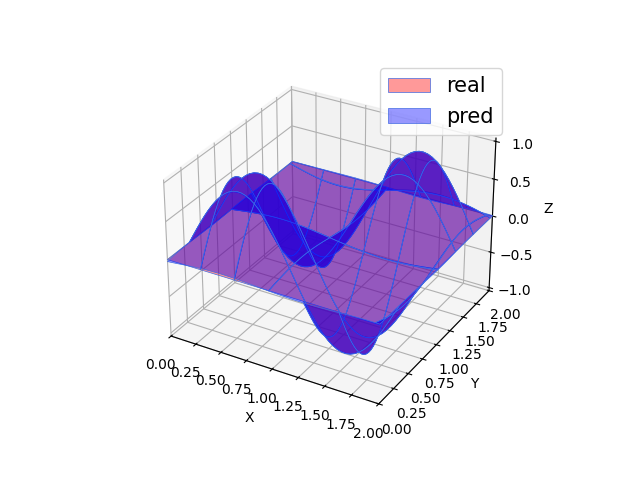

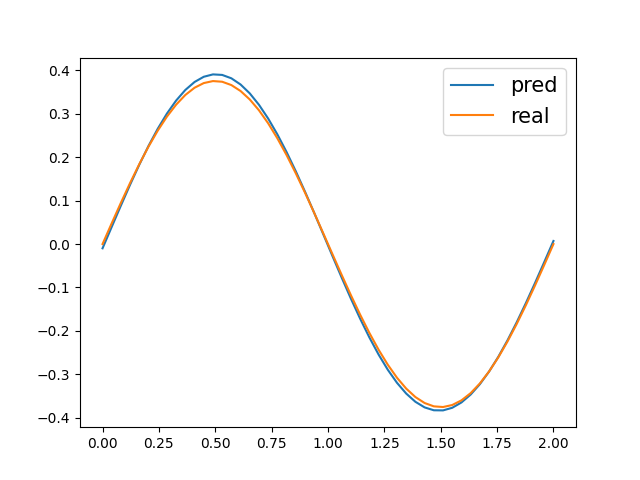

In [28]:
import plotting

%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
plotter.plot3d()
plotter.plot2d_fix_x(3)

# Accuracy calculation

In [33]:
pred = np.array([i[0] for i in pred_u.reshape(np.prod(pred_u.shape), 1)])
true = np.array([i[0] for i in true_u.reshape(np.prod(true_u.shape), 1)])

In [34]:
from accuracy import *

print("Accuracy:", good_perc(pred, true), maape(pred, true))

Accuracy: 0.8616 0.08952720963184477
